## Introduction


*Objective: Create a function to analyze the effect of gene knockouts on single-cell gene expression data using pre-trained foundation models. Compare embeddings before and after knockout and classify the samples.*

In this notebook, I analyze the effect of gene knockouts on single-cell gene expression data using pre-trained foundation models. The analysis includes:
- Applying the perturbation (knock-outs) of specific genes on specific cell types within the dataset.
- Generating embeddings for both the original and perturbed data using a pre-trained foundation model.
- Visualizing and comparing these embeddings through distance metrics.
- Building a classifier to distinguish between perturbed and unperturbed samples.


This tutorial is made to run with GPU support if available (CPU otherwise), and can be used in Google colab. If you'd like to open this notebook in colab, you can use the following link. [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/elisagdelope/scGPT_knockout_embeddings/blob/main/scGPT_knockout_embeddings.ipynb)

## Setup

In [ ]:
try:
    import helical
except:
    !pip install git+https://github.com/helicalAI/helical.git |tail -n 1
    !pip install numpy==1.23.5
    import helical

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/helical/models/scgpt/model_dir/multiomic_model.py:19: UserWarning: flash_attn is not installed


In [ ]:
!pip install anndata torch transformers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import os
import requests
import anndata as ad
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load data from the PBMC

For convenience and illustrative purposes, I used the single-cell RNA sequencing data of Peripheral Blood Mononuclear Cells (PBMC) that is provided by Helical's download link.


In [ ]:
url = "https://helicalpackage.blob.core.windows.net/helicalpackage/data/10k_pbmcs_proc.h5ad"

# Extract the filename and download the file
filename = url.split("/")[-1]

# Check if the file already exists in the current directory
if os.path.exists(filename):
    print(f"{filename} already exist. Skipping downloads.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {filename} successfully.")
    else:
        print(f"Failed to download {filename}.")

10k_pbmcs_proc.h5ad already exist. Skipping downloads.


In [ ]:
# load data
ann_data = ad.read_h5ad("10k_pbmcs_proc.h5ad")
ann_data

AnnData object with n_obs × n_vars = 11990 × 12000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_types', 'hvg'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

#### Data exploration

In [ ]:
print(ann_data.n_vars) # genes
print(ann_data.var_names[0:5])
print(ann_data.n_obs) # cells
print(ann_data.obs_names[0:5])

12000
Index(['SAMD11', 'PLEKHN1', 'HES4', 'ISG15', 'AGRN'], dtype='object')
11990
Index(['AAACCTGAGCTAGTGG-1', 'AAACCTGCACATTAGC-1', 'AAACCTGCACTGTTAG-1',
       'AAACCTGCATAGTAAG-1', 'AAACCTGCATGAACCT-1'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The dataset contains information of 12000 genes (ids are gene symbols) and 11990 cells.

In [ ]:
# metadata of genes
ann_data.var.head()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

,gene_symbols,n_counts-0,n_counts-1,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm
SAMD11,SAMD11,7.0,4.0,11.0,True,8398.0,0.000917,0.000917,0.937632
PLEKHN1,PLEKHN1,30.0,10.0,39.0,True,7424.0,0.003253,0.003409,0.945401
HES4,HES4,580.0,294.0,855.0,True,189.0,0.071309,0.200353,2.573027
ISG15,ISG15,4014.0,1888.0,5705.0,True,269.0,0.475813,1.413837,2.089724
AGRN,AGRN,36.0,8.0,41.0,True,7906.0,0.003420,0.003575,0.941332


In [ ]:
# metadata of cells
ann_data.obs.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,n_counts,batch,labels,str_labels,cell_type
AAACCTGAGCTAGTGG-1,4520.0,0,2,CD4 T cells,CD4 T cells
AAACCTGCACATTAGC-1,2788.0,0,2,CD4 T cells,CD4 T cells
AAACCTGCACTGTTAG-1,4667.0,0,1,CD14+ Monocytes,CD14+ Monocytes
AAACCTGCATAGTAAG-1,4440.0,0,1,CD14+ Monocytes,CD14+ Monocytes
AAACCTGCATGAACCT-1,3224.0,0,3,CD8 T cells,CD8 T cells


In [ ]:
import pandas as pd
# matrix of cells x gene counts
df = pd.DataFrame(ann_data.X.toarray(), index=ann_data.obs_names, columns=ann_data.var_names)
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SAMD11,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,TNFRSF18,TNFRSF4,SDF4,...,S100B,PRMT2,MT-ND1,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND4,MT-ND6
AAACCTGAGCTAGTGG-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,1.0,7.0,15.0,9.0,0.0,1.0,14.0,8.0,0.0
AAACCTGCACATTAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,3.0,6.0,0.0,3.0,6.0,4.0,1.0
AAACCTGCACTGTTAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,7.0,37.0,25.0,0.0,10.0,23.0,19.0,0.0
AAACCTGCATAGTAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,6.0,48.0,25.0,0.0,16.0,22.0,15.0,0.0
AAACCTGCATGAACCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,19.0,16.0,0.0,10.0,13.0,17.0,0.0


## Apply knockout perturbation & generate embeddings

The function *perturbation_embeddings* allows to perform knock-out perturbation for specific genes and cell types, and generates embeddings both for the both original and perturbed data from a specific model (implemented for Geneformer and scGPT from Helica, default is scGPT).

In [ ]:
def perturbation_embeddings(adata, kgenes, cell_type=None, gene_ids_col="gene_symbols", model_name="scGPT", batch_size=64, device="cpu"):
  """
  Perturbs gene expression of specific cell types by knocking out specified genes and generates
  embeddings from the model for both the original and perturbed data.
  Params:
  - adata: AnnData object containing single-cell expression data.
  - kgenes: List of genes to knock out (gene symbols).
  - cell_type: List of cell types to perturb. Default is None (perturb all cells).
  - model_name: Name of the model to use for generating embeddings ("scGPT" or "Geneformer").
  - batch_size: Batch size for processing data.
  - device: Device to use for computation ("cpu" or "cuda").

  Returns:
  - original_embeddings: Embeddings for the original data.
  - perturbed_embeddings: Embeddings for the perturbed data.
  """
  def perturb_data(adata, kgenes, cell_type=None):
    """
    Perturbs gene expression of specific cell types by knocking out specified genes.
    """
    p_adata = adata.copy()
    gene_indices = [adata.var_names.get_loc(gene) for gene in kgenes]
    if cell_type is None: # knock out genes in all cells
        p_adata.X[:, gene_indices] = 0
    else:
        for ctype in cell_type:
            cells2perturb = adata.obs[adata.obs['cell_type'] == ctype].index.to_list()
            cell_indices = [adata.obs_names.get_loc(cell) for cell in cells2perturb]
            # Set the expression of the specified genes to zero in the specified cells
            p_adata.X[gene_indices,:][:,cell_indices] = 0
    return p_adata

  def load_model(model_name, device, batch_size, accelerator=True):
    """
    Currently implemented for scGPT and Geneformer models, loaded from Helical.
    """
    if model_name == "scGPT":
      model_config = scGPTConfig(batch_size=batch_size, device=device, accelerator=accelerator)
      model = scGPT(configurer = model_config)
    elif model_name == "Geneformer":
      model_config = GeneformerConfig(batch_size=batch_size, device=device, accelerator=accelerator)
      model = Geneformer(configurer = model_config)
    else:
      raise ValueError("Model not supported")
    return model

  def generate_embeddings(adata, model, gene_ids_col):
    """
    Generates embeddings for the given AnnData object using the provided model.
    Currently implemented for Helical model.
    """
    dataset = model.process_data(adata, gene_names=gene_ids_col)
    embeddings = model.get_embeddings(dataset)
    return embeddings

  # generate perturbed data
  p_ann_data = perturb_data(ann_data, kgenes, cell_type)

  # load the model
  model = load_model(model_name, device, batch_size)

  # generate embeddings
  original_embeddings = generate_embeddings(ann_data, model, gene_ids_col)
  perturbed_embeddings = generate_embeddings(p_ann_data, model, gene_ids_col)

  return original_embeddings, perturbed_embeddings


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's knockout a fraction of the genes (random, first k genes) in the dataset, for two particular cell types: 'CD4 T cells' and 'B cells'.

As for the model, I used the scGPT pre-trained model since Geneformer requires larger GPU memory than available in Google Colab.

In [ ]:
k=0.9 # 90% of genes to be knocked out
kgenes = ann_data.var["gene_symbols"][0:int(len(ann_data.var["gene_symbols"])*k)].to_list()
print(len(kgenes)) # 6000
print(kgenes[0:10])

# Create perturbed data knocking out genes in specific cell types
cell_types = ['CD4 T cells', 'B cells']

10800
['SAMD11', 'PLEKHN1', 'HES4', 'ISG15', 'AGRN', 'C1orf159', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4']


In [ ]:
embeddings, p_embeddings = perturbation_embeddings(ann_data, kgenes, gene_ids_col="gene_symbols", cell_type=cell_types, model_name="scGPT", batch_size=64, device=device)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: Imp

In [ ]:
print(embeddings.shape)
print(p_embeddings.shape)

(11990, 512)
(11990, 512)


As a safety check, I observed the embeddings of the original and perturbed cells have the same shape.

In [ ]:
# Geneformer -> OutOfMemoryError: CUDA out of memory. Tried to allocate 230.00 MiB. GPU
# embeddings, p_embeddings = perturbation_embeddings(ann_data, kgenes, gene_ids_col="gene_symbols", cell_type=cell_types, model_name="Geneformer", batch_size=64, device=device)


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Map:   0%|          | 0/11990 [00:00<?, ? examples/s]

  0%|          | 0/188 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 230.00 MiB. GPU 

## Visualization of original and perturbed embeddings

Here embeddings are plotted by reducing their dimensionality from 512 to 2 (axes) with UMAP.  The embeddings are also compared via two distance metrics: euclidean and cosine distance.


In [ ]:
# Generate labels: 0 for original, 1 for perturbed
original_labels = np.zeros(embeddings.shape[0])
perturbed_labels = np.ones(p_embeddings.shape[0])

# Combine embeddings and labels
combined_embeddings = np.vstack((embeddings, p_embeddings))
combined_labels = np.concatenate((original_labels, perturbed_labels))
print(combined_embeddings.shape)
print(combined_labels.shape)

(23980, 512)
(23980,)


In [ ]:
# visualize embeddings through UMAP 2-dim-reduced representation
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_rep = umap_reducer.fit_transform(combined_embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


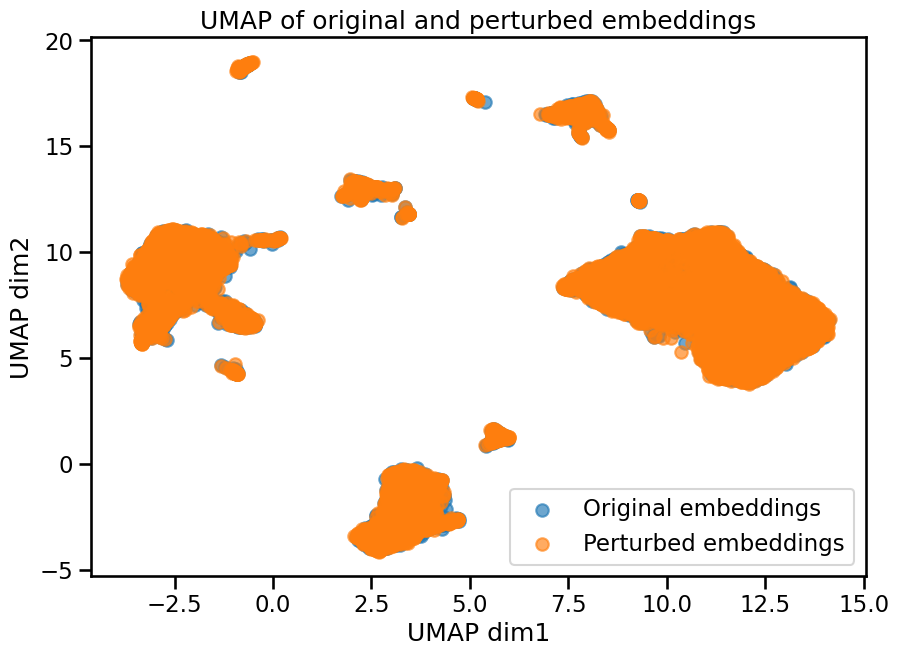

In [ ]:
# plot UMAP
plt.figure(figsize=(10, 7))
plt.scatter(umap_rep[combined_labels == 0, 0], umap_rep[combined_labels == 0, 1], label='Original embeddings', alpha=0.65)
plt.scatter(umap_rep[combined_labels == 1, 0], umap_rep[combined_labels == 1, 1], label='Perturbed embeddings', alpha=0.65)
plt.xlabel('UMAP dim1')
plt.ylabel('UMAP dim2')
plt.legend()
plt.title('UMAP of original and perturbed embeddings')
plt.show()


Visually, it seems that the knockouts on the specific cells selected have little impact in the embeddings (at least in the low dimensional UMAP space). Let's see with the euclidean and cosine distances:

In [ ]:
from scipy.spatial.distance import euclidean, cosine

# Calculate pairwise distances
euclidean_distances = [euclidean(embeddings[i], p_embeddings[i]) for i in range(len(embeddings))]
cosine_distances = [cosine(embeddings[i], p_embeddings[i]) for i in range(len(embeddings))]

# Calculate average distance
average_distance = np.mean(euclidean_distances)
print(f'Average euclidean distance: {average_distance}')
average_distance = np.mean(cosine_distances)
print(f'Average cosine distance: {average_distance}')

Average euclidean distance: 0.1174316582634262
Average cosine distance: 0.007494796617170459


Lower values of distance suggest rather closer embeddings (i.e., the original and perturbed are rather similar). However, the interpretability of distance among embeddings in absolute terms is not straightforward. I can say though that I tried different k ratio of genes knocked out, and the distance increased with the number of knockouts.

The cosine distance is very small, indicating that the original and knockout embeddings are highly aligned in terms of their orientation, which is also in lign with the observations in the UMAP representation.

## Classification task


This is a simple, 3-layer NN classifier of embeddings into perturbed and unperturbed samples. The previously generated embeddings for original and perturbed samples were split into training and test.

In [ ]:
# Convert to tensor
X = torch.tensor(combined_embeddings)
y = torch.tensor(combined_labels, dtype=torch.long)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# define model
class MLP3l(torch.nn.Module):
    def __init__(self, in_f, h1_f, h2_f, p_dropout, out_f=2):
        super(MLP3l, self).__init__()
        torch.manual_seed(42)
        self.lin1 = nn.Linear(in_f, h1_f)
        self.lin2 = nn.Linear(h1_f, h2_f)
        self.lin3 = nn.Linear(h2_f, out_f)
        self.bn1 = nn.BatchNorm1d(h1_f)
        self.bn2 = nn.BatchNorm1d(h2_f)
        self.p_dropout = p_dropout

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.bn1(x)
        x = F.dropout(x, p=self.p_dropout, training=self.training)
        x = F.relu(self.lin2(x))
        x = self.bn2(x)
        x = F.dropout(x, p=self.p_dropout, training=self.training)
        out = self.lin3(x)
        return out


In [ ]:
# Initialize the model & config
model = MLP3l(in_f=X.shape[1], h1_f=64, h2_f=128, p_dropout=0.2, out_f=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
n_epochs = 50

In [ ]:
train_losses = []
val_losses = []
accuracies = []
aucs = []
model.to(device)

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(batch_y.view_as(pred)).sum().item()
            all_preds.extend(outputs[:, 1].cpu().numpy())  # taking the predicted probability for class 1
            all_labels.extend(batch_y.cpu().numpy())

    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracies.append(accuracy)
    auc = roc_auc_score(all_labels, all_preds)
    aucs.append(auc)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, AUC: {auc:.2f}%, Accuracy: {accuracy:.2f}%')

Epoch 1/50, Train Loss: 0.7135, Val Loss: 0.7029, AUC: 0.50%, Accuracy: 49.56%
Epoch 2/50, Train Loss: 0.7028, Val Loss: 0.7009, AUC: 0.50%, Accuracy: 49.40%
Epoch 3/50, Train Loss: 0.7025, Val Loss: 0.6983, AUC: 0.49%, Accuracy: 49.02%
Epoch 4/50, Train Loss: 0.7012, Val Loss: 0.7048, AUC: 0.49%, Accuracy: 49.35%
Epoch 5/50, Train Loss: 0.6987, Val Loss: 0.7037, AUC: 0.50%, Accuracy: 49.75%
Epoch 6/50, Train Loss: 0.6987, Val Loss: 0.6970, AUC: 0.50%, Accuracy: 49.67%
Epoch 7/50, Train Loss: 0.6977, Val Loss: 0.7027, AUC: 0.49%, Accuracy: 49.96%
Epoch 8/50, Train Loss: 0.6966, Val Loss: 0.6981, AUC: 0.49%, Accuracy: 50.10%
Epoch 9/50, Train Loss: 0.6957, Val Loss: 0.6956, AUC: 0.49%, Accuracy: 49.27%
Epoch 10/50, Train Loss: 0.6950, Val Loss: 0.6954, AUC: 0.50%, Accuracy: 49.54%
Epoch 11/50, Train Loss: 0.6947, Val Loss: 0.6943, AUC: 0.50%, Accuracy: 50.02%
Epoch 12/50, Train Loss: 0.6944, Val Loss: 0.6945, AUC: 0.49%, Accuracy: 49.21%
Epoch 13/50, Train Loss: 0.6941, Val Loss: 0.6935

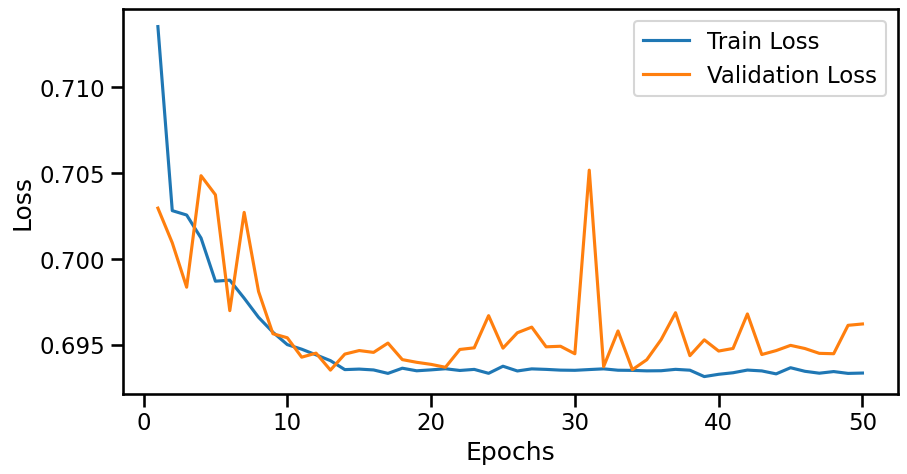

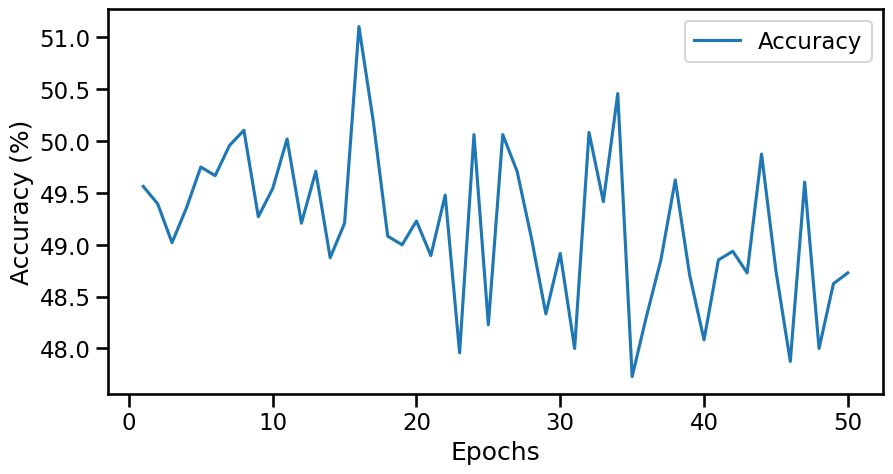

In [ ]:
# Plotting training & val losses
plt.figure(figsize=(10,5))
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, n_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()